
# Creation of a quantization, use and evaluation pipeline, featuring LLaMA2 7B model and Quanto

In this project, we evaluate the impact quantization has in a common use LLM model, in our case LLaMA 2 7B, evaluating it in a sentiment analysis task. Our pipeline is defined as follows:
- Add a classification layer at the end of the not-quantized model and train this new model with our dataset.
- Quantize the model using **Quanto** in two variants, 8bit and 4bit quantization.
- Compare the performance of our models (not quantized, 4bits and 8bits) in terms of precission, memory use, inference speed and emissions.

![Pipeline Diagram](./Quanto_Pipeline.png)

We follow this approach because it is the easiest approach to follow. Another option would be to firstly quantize the base model and then add the classification layer and train it. In fact, one could think this approach is better than the previously exposed. However, lots of problems are encountered doing this because fine tuning an already quantized model is not a good practice. 

### Goals
1. Analize the impact quantization has on performance.
2. Compare the efficiency and precision of the quantized models with the not-quantized model.


## Quanto

**Quanto** (Quantization for Transformers Optimization) is a cutting-edge quantization method specifically tailored to optimize the deployment of large language models while minimizing the trade-off between efficiency and accuracy. Developed as a **Post-Training Quantization (PTQ)** technique, Quanto enables efficient scaling of Transformer-based models to hardware with limited computational and memory resources. By leveraging advanced techniques for weight distribution analysis and precision tuning, Quanto preserves the essential properties of the model while significantly reducing its memory footprint and computational demands.

The **core principle** of Quanto lies in precision-aware quantization, which uses statistical and structural insights into Transformer layers to determine the optimal precision for different components of the model. Unlike uniform quantization approaches that treat all weights or activations equally, Quanto analyzes the sensitivity of weights, biases, and activations to precision loss. This method allows Quanto to apply mixed-precision quantization—assigning higher precision to critical components while aggressively compressing less sensitive ones. For example, attention weights and projection layers often retain higher precision (e.g., 16-bit), while feed-forward network (FFN) components can be quantized to lower precisions such as 4-bit or even ternary (3-bit).

### Key Features of Quanto

1. **Adaptive Precision Assignment**:
   Quanto employs a layer-wise and component-wise analysis to determine the sensitivity of each weight to quantization errors. This involves measuring the distribution of values and their impact on downstream activations. Sensitive parameters are assigned higher precision to mitigate performance degradation, while less critical parameters are quantized more aggressively.

2. **Error-Minimization Framework**:
   Using a combination of **quantization noise metrics** and **statistical approximations**, Quanto minimizes the cumulative error introduced during the quantization process. It evaluates the quantization effect using metrics such as:
   \[
   \|WX - \hat{W}X\|^2,
   \]
   where \( W \) are the original weights, \( \hat{W} \) are the quantized weights, and \( X \) represents input activations. This framework allows Quanto to iteratively refine quantization decisions layer by layer.

3. **Attention to Transformer-Specific Structures**:
   Quanto recognizes the unique structural properties of Transformers, such as self-attention mechanisms and feed-forward layers. It adapts its quantization strategy to maintain alignment and stability in multi-head attention, ensuring that critical patterns in the attention matrices are preserved.

### Quantization Workflow in Quanto

1. **Statistical Analysis and Sensitivity Scoring**:
   - A small calibration dataset is used to analyze the activation ranges and weight distributions of each layer.
   - Sensitivity scoring is performed to rank the importance of individual weights and activations within each layer.

2. **Precision Allocation**:
   - Mixed-precision configurations are applied based on sensitivity scores, with critical weights assigned higher precision (e.g., 8-bit or 16-bit) and non-critical ones reduced to lower precision (e.g., 4-bit or 3-bit).
   - Quantization scaling factors are computed to minimize the difference between full-precision and quantized outputs.

3. **Layer-Wise Quantization**:
   - Quanto processes each Transformer layer sequentially, ensuring that errors introduced by quantized layers do not propagate uncontrollably to subsequent layers.
   - Outputs of quantized layers are recalculated dynamically to serve as inputs for the next layer's quantization step.

4. **Block-Wise Optimization**:
   - For scalability in very large models, Quanto applies block-wise quantization to divide weight matrices into manageable submatrices, reducing memory and computation overhead while maintaining precision for critical components.

### Inference and Performance Optimization

1. **Dynamic Weight Reconstruction**:
   Quantized weights are stored in low-precision formats and are dynamically reconstructed to higher precision (if needed) during inference, balancing memory efficiency with computational accuracy.

2. **Custom Kernels for Speed**:
   Quanto leverages optimized inference kernels designed for hardware accelerators like NVIDIA GPUs. These kernels minimize memory transfer overhead and enable efficient execution of quantized matrix operations.

3. **Memory Efficiency**:
   With Quanto, large Transformer models can fit into smaller memory footprints, enabling deployment on single GPUs or edge devices. For instance, a 3-bit quantized LLaMA-2-13B model can run on a single NVIDIA A100, significantly reducing infrastructure requirements.

4. **Robustness in Token-by-Token Tasks**:
   In autoregressive tasks such as text generation, Quanto optimizes inference latency by compressing weights without disrupting sequential token generation, maintaining smooth token predictions.

### Advantages of Quanto

- **High Compression Ratios**: Quanto achieves significant reductions in model size, often compressing models by over 4x with minimal impact on accuracy.
- **Scalable to Large Models**: Designed for scaling Transformer architectures like LLaMA, GPT, and BERT, Quanto can handle models with billions of parameters.
- **Hardware-Agnostic Design**: Compatible with a wide range of hardware platforms, including GPUs, TPUs, and edge devices.

In summary, Quanto combines precision-aware quantization with Transformer-specific optimizations to enable efficient deployment of large language models in resource-constrained environments. Its adaptive, iterative, and hardware-efficient approach makes it a powerful tool for modern AI applications that demand high performance and low latency.

## Hardware and software

### Hardware
- CPU: Intel(R) Xeon(R) Silver 4316 CPU @ 2.30GHz
- RAM: 985 GB
- GPU: NVIDIA A100-PCIE-40GB
### Software
For this project, we used the following python libraries: torch, transformers, time and datasets, among others. Of course, all the libraries that these libraries have dependencies with are needed too.
We also used some other libraries or tools that help to evaluate the results. For example, the library CodeCarbon was used to collect emissions data, and the Weights and Biases (Wandb) platform was used to collect and visualize metrics. 


## Project pipeline

### 1. Base model preparation
The base model used is **LLaMA 2 (7B)**. We added a classifier layer to it by loading it with the LlamaForSequenceClassification function from the Transformers library. Then, fine tuning was performed using the **TweetEval** dataset, focusing on the sentiment classification task on its training subset. To make the fine-tuning more efficient and lightweight, Low-Rank Adaptation (LoRA) was applied to the attention layers using the PEFT library, reducing the number of trainable parameters. Training was carried out on a single  NVIDIA A100 40GB GPU using the Hugging Face ***Trainer*** API with a learning rate of $2 \times 10^{-5}$, a batch size of 8, and a total of 3 epochs.

### 2. Quantization 
Quantization was performed using **Quanto**. With this quantization method we took 2 quantization options: **8 bits** and **4 bits**. Note that we just quantized the weights in this case.
This leads us to have 3 different models: **quantized to 8 bits**, **quantized to 4 bits** and **not quantized**.

### 3. Evaluation
These three models were evaluated and compared in terms of: **accuracy**, **memory use**, **inference speed** and **emissions**. The dataset used was the same we used for the training before, but we used the test subset.


## Results
### Accuracy results
We now show the results obtained for the accuracy of each of the three models:

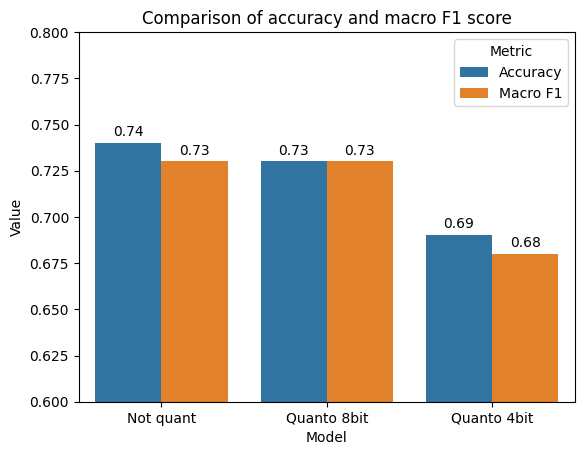

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'Quanto 8bit', 'Quanto 4bit'],
    'Accuracy': [0.74, 0.73, 0.69],
    'Macro F1': [0.73, 0.73, 0.68]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of accuracy and macro F1 score')
plt.ylim(0.6, 0.8)
plt.show()

We observe how the accuracy is higher with the base model and, between the quantized models, the 8-bit variant has a higher accuracy, although differences are minimal. Between the quantized models, the 8 bit variant performs better than the 4bit one.


### Memory use results

Measuring memeory needs is not an easy task. We decided to check the maximum memory need while inference (in GPU). Note that this measure tends to be higher due to needs associated with inference, specially when using batches.

We only measured this and not the disk memory required because of the way we store the models. Since we used LoRA to fine tune and train our base model with the classification layer, we don't store the whole model explicitly, but only the LoRA adpaters generated. Therefore, we are unable to compare additional memory usage metrics, such as disk memory requirements.

Now we show the maximum memory needed for inference for each model and inference configuration:

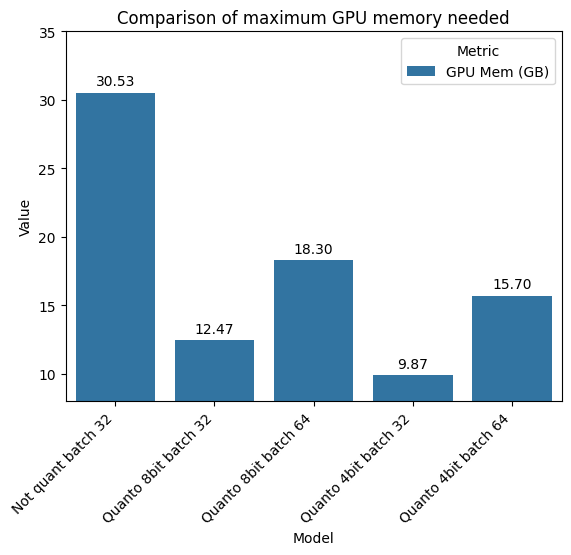

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'Quanto 8bit batch 32', 'Quanto 8bit batch 64', 'Quanto 4bit batch 32', 'Quanto 4bit batch 64'],
    'GPU Mem (GB)': [30.53, 12.47, 18.30, 9.87, 15.70]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of maximum GPU memory needed')
plt.ylim(8.0, 35.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how the maximum memory usage in GPU during inference increases with batch size for all models. The bigger the batch size, the higher the memory needs. In addition to this, we see how the base model needs considerable more memory compared to both quantized models, and between the quantized models, the 4bit variant requires less memory than the 8bit one.

### Inference speed results

In this section we show the results obtained for inference time and quantization time:  

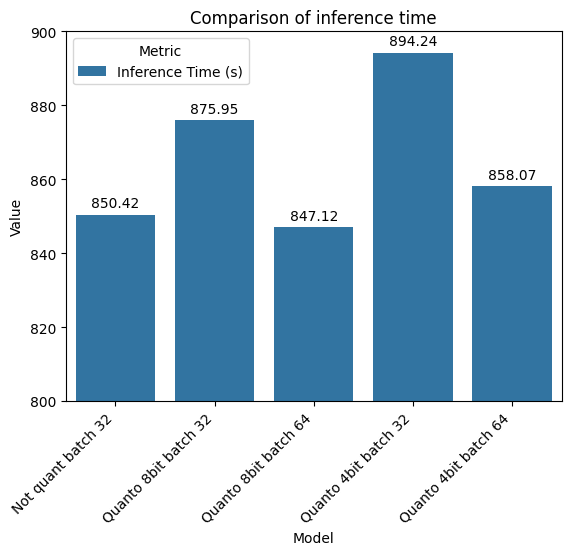

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'Quanto 8bit batch 32', 'Quanto 8bit batch 64', 'Quanto 4bit batch 32', 'Quanto 4bit batch 64'],
    'Inference Time (s)': [850.42, 875.95, 847.12, 894.24, 858.07]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of inference time')
plt.ylim(800.0, 900.0)
plt.xticks(rotation=45, ha='right')
plt.show()

Here we see some surprising results. Opposite to what would be expected, the base model performs better than all the quantized models. Between these, it seems like the lower the bit count, the slower is the model, which is very surprising, although differences are small. 

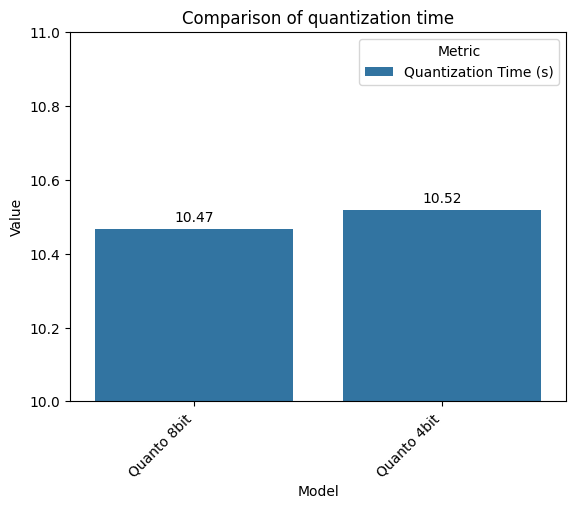

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Quanto 8bit', 'Quanto 4bit'],
    'Quantization Time (s)': [10.468, 10.519]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of quantization time')
plt.ylim(10.0, 11.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how quantization times for both quantized models are practically the same.

### Emissions results

The emissions are a little challenging to measure and compare. This is because we need to decide if we take into account the emissions generated during the quantization of the models. Our approach will show the resuts obtained for evaluation separated from the emissions for the quantization process, but will take them into consideration when comparing. We will measure the emissions of CO<sub>2</sub> in kilograms of CO<sub>2</sub>-equivalents \[CO<sub>2</sub>eq\]

The emissions generated by the evaluation process and the quantization were:

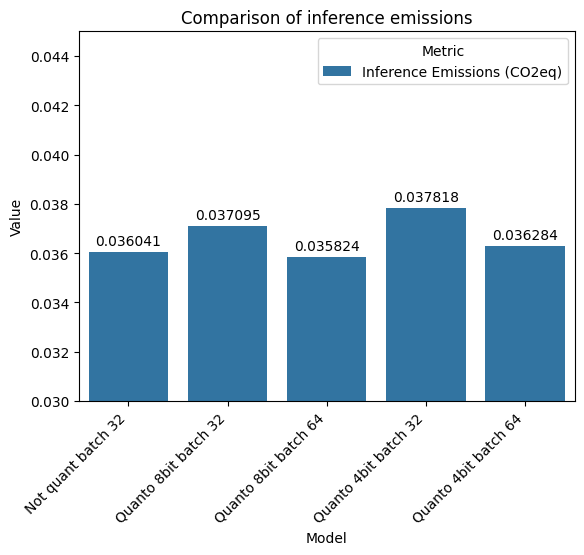

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant batch 32', 'Quanto 8bit batch 32', 'Quanto 8bit batch 64', 'Quanto 4bit batch 32', 'Quanto 4bit batch 64'],
    'Inference Emissions (CO2eq)': [0.036041, 0.037095, 0.035824, 0.037818, 0.036284]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3)
plt.title('Comparison of inference emissions')
plt.ylim(0.03, 0.045)
plt.xticks(rotation=45, ha='right')
plt.show()

Here we see how the emissions results follow the same trend seen in speed results. Opposite to what would be expected, the base model has lower emissions than all the quantized models. Between these, it seems like the lower the bit count, the higher emissions which is very surprising, although differences are minimal. 

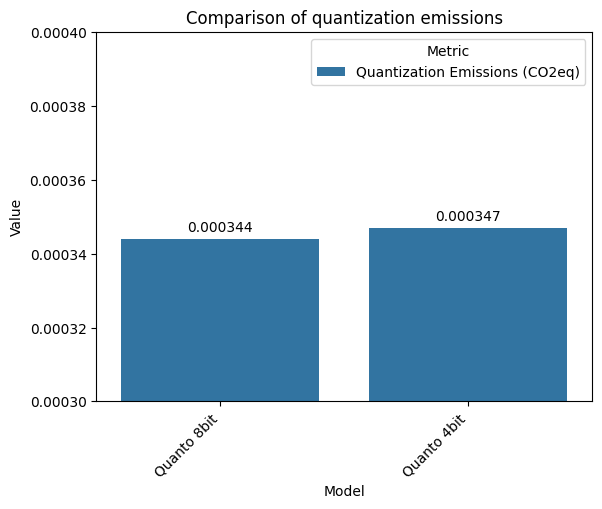

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Quanto 8bit', 'Quanto 4bit'],
    'Quantization Emissions (CO2eq)': [0.000344, 0.000347]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3)
plt.title('Comparison of quantization emissions')
plt.ylim(0.0003, 0.0004)
plt.xticks(rotation=45, ha='right')
plt.show()

Following the same trend seen with quantization times before, we see how emissions for quantization of both models are really similar.


## Conclusions

Results show that:

1. Quantization does in fact reduce accuracy, and the lower the bit count, the higher this drop is. However, the drop with **Quanto** is not as significant, specially with the 8 bit model.
2. Quantized models are noticeably better in terms of memory usage compared to the base model.
3. Contrary to what would be expected, quantized models with **Quanto** are not faster than the base model. This probably is due to the nature of this quantization method.
4. In a similar fashion as inference time, emissions are higher in the quantized models. This is coherent with the fact that the inference time is higher. 

